In [1]:
#importing relevant libraries
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from flask import Flask, render_template
from sqlalchemy import create_engine
import pandas as pd
import datetime as dt
import numpy as np
import dbinfo
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pickle 
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading in availability data from sql and creating dataframe
engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(dbinfo.USER, dbinfo.PASSWORD, dbinfo.URI, dbinfo.PORT, dbinfo.DB), echo=True)
df = pd.read_sql("SELECT available_bikes, last_update FROM availability WHERE number = 2;", engine)

df.to_json(orient='records')

2021-04-15 11:23:28,701 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-15 11:23:28,702 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:29,028 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-15 11:23:29,029 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:29,661 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-15 11:23:29,662 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:30,301 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-15 11:23:30,302 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:30,646 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-15 11:23:30,647 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:31,081 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT available_bikes, last_update FROM availability WHERE number = 2;`
2021-04-15 11:23:31,082 INFO sqlalchemy.engin

'[{"available_bikes":11,"last_update":1614458196000},{"available_bikes":11,"last_update":1614458805000},{"available_bikes":13,"last_update":1614462379000},{"available_bikes":13,"last_update":1614462988000},{"available_bikes":13,"last_update":1614463597000},{"available_bikes":13,"last_update":1614464206000},{"available_bikes":13,"last_update":1614464815000},{"available_bikes":13,"last_update":1614465424000},{"available_bikes":13,"last_update":1614466033000},{"available_bikes":13,"last_update":1614466642000},{"available_bikes":13,"last_update":1614467251000},{"available_bikes":13,"last_update":1614467860000},{"available_bikes":13,"last_update":1614468468000},{"available_bikes":13,"last_update":1614469078000},{"available_bikes":13,"last_update":1614469687000},{"available_bikes":13,"last_update":1614470295000},{"available_bikes":13,"last_update":1614470904000},{"available_bikes":13,"last_update":1614471513000},{"available_bikes":13,"last_update":1614472342000},{"available_bikes":13,"last_u

In [3]:
#reading in weather data from sql and creating dataframe
engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(dbinfo.USER, dbinfo.PASSWORD, dbinfo.URI, dbinfo.PORT, dbinfo.DB), echo=True)
weather_df = pd.read_sql("SELECT * FROM weather;", 
        engine)
weather_df.to_json(orient='records')

2021-04-15 11:23:33,225 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-15 11:23:33,226 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:33,551 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-15 11:23:33,552 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:34,188 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-15 11:23:34,189 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:34,808 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-15 11:23:34,812 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:35,139 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-15 11:23:35,140 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:35,560 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT * FROM weather;`
2021-04-15 11:23:35,561 INFO sqlalchemy.engine.base.Engine {}
2021-04-15 11:23:35,674 INFO sql

'[{"time":1614463327000,"temp":7.84,"humidity":81,"main":"Clouds","description":"broken clouds","wind_speed":1.03,"visibility":null,"icon":null},{"time":1614463776000,"temp":7.95,"humidity":81,"main":"Clouds","description":"broken clouds","wind_speed":1.03,"visibility":null,"icon":null},{"time":1614470976000,"temp":7.69,"humidity":87,"main":"Clouds","description":"broken clouds","wind_speed":2.06,"visibility":null,"icon":null},{"time":1614478177000,"temp":6.2,"humidity":93,"main":"Clouds","description":"broken clouds","wind_speed":1.54,"visibility":null,"icon":null},{"time":1614485377000,"temp":4.51,"humidity":87,"main":"Clouds","description":"broken clouds","wind_speed":0.51,"visibility":null,"icon":null},{"time":1614492577000,"temp":3.8,"humidity":100,"main":"Clouds","description":"scattered clouds","wind_speed":1.03,"visibility":null,"icon":null},{"time":1614499778000,"temp":3.21,"humidity":93,"main":"Fog","description":"fog","wind_speed":1.54,"visibility":null,"icon":null},{"time":

In order to merge the weather and availabilty datafrmes together at suitbale time points, a column will be added to both datframes "interval", this will round the last update time to the nearest half hour, then the datframes will be merged together using an inner join. Using this new dataframe, the interval colum can then be converted to the hour [0,23] and the weekday [0,6]

In [4]:
weather_df

,time,temp,humidity,main,description,wind_speed,visibility,icon
0,2021-02-27 22:02:07,7.84,81,Clouds,broken clouds,1.03,NaN,None
1,2021-02-27 22:09:36,7.95,81,Clouds,broken clouds,1.03,NaN,None
2,2021-02-28 00:09:36,7.69,87,Clouds,broken clouds,2.06,NaN,None
3,2021-02-28 02:09:37,6.20,93,Clouds,broken clouds,1.54,NaN,None
4,2021-02-28 04:09:37,4.51,87,Clouds,broken clouds,0.51,NaN,None
...,...,...,...,...,...,...,...,...
1484,2021-04-15 08:06:12,7.48,100,Clouds,few clouds,2.57,10000.0,02d
1485,2021-04-15 08:36:12,8.68,93,Clouds,few clouds,3.60,10000.0,02d
1486,2021-04-15 09:06:13,9.98,76,Clouds,few clouds,3.09,10000.0,02d
1487,2021-04-15 09:36:13,10.70,71,Clouds,few clouds,3.09,10000.0,02d


In [5]:
df

,available_bikes,last_update
0,11,2021-02-27 20:36:36
1,11,2021-02-27 20:46:45
2,13,2021-02-27 21:46:19
3,13,2021-02-27 21:56:28
4,13,2021-02-27 22:06:37
...,...,...
6556,1,2021-04-15 09:49:07
6557,1,2021-04-15 09:59:13
6558,1,2021-04-15 10:09:20
6559,2,2021-04-15 10:12:53


In [6]:
#intervals of 30 minutes
threshold_ns = 30 * 60 * 1e9

# compute "interval" to which each update belongs
df['interval'] = pd.to_datetime(np.round(df.last_update.astype(np.int64) / threshold_ns) * threshold_ns)
weather_df['interval'] = pd.to_datetime(np.round(weather_df.time.astype(np.int64) / threshold_ns) * threshold_ns)

In [7]:
#join dataframes together based on interval (inner join)
merged_df = pd.merge(df,weather_df,  how ='inner', on='interval')

In [8]:
#create column for hour and weekday based off of the interval 
merged_df['hour'] = list(map(lambda v : v.hour, merged_df['interval']))
merged_df['weekday'] = list(map(lambda v : v.weekday(), merged_df['interval']))

In [9]:
#dropping all rows between hours of 12AM to 5AM when the stations are closed
#keeping these rows may skew results.
merged_df = merged_df[merged_df['hour'] > 4]

In [10]:
#changing categorical variables from type object to type category
merged_df['main'] = merged_df['main'].astype('category')

In [11]:
#converting categorical data into dummy or indicator variables 
dummy_columns = ['main']
for col in dummy_columns:
    dummies = pd.get_dummies(merged_df[col], prefix=col)
    merged_df = pd.concat([merged_df,dummies], axis = 1)

#dropping unused columns
dropped_columns = ['last_update','time','description','icon', 'interval','main','visibility']
merged_df = merged_df.drop(dropped_columns, axis=1)

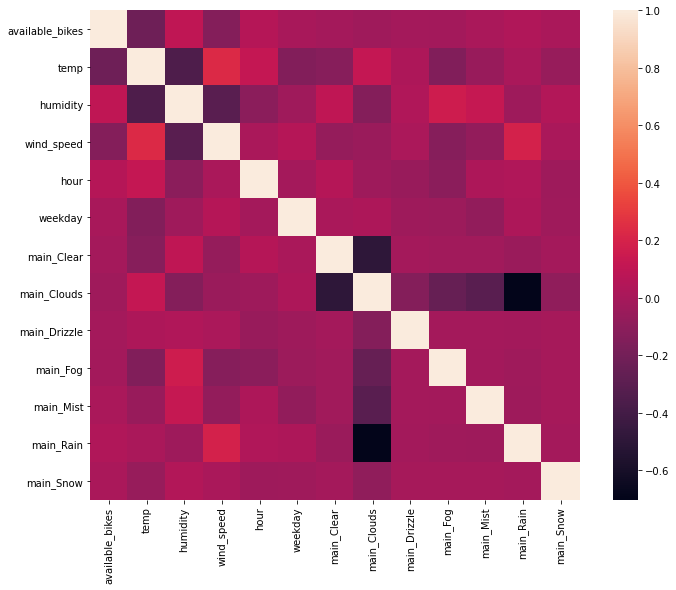

In [12]:
#correlation matrix
corrmat = merged_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

In [13]:
#convert hour and weekday to categorical data type 
merged_df['hour'] = merged_df['hour'].astype('category')
merged_df['weekday'] = merged_df['weekday'].astype('category')

In [14]:
#converting categorical data into dummy or indicator variables 
time_columns = ['hour','weekday']
for col in time_columns:
    dummies = pd.get_dummies(merged_df[col], prefix=col)
    merged_df = pd.concat([merged_df,dummies], axis = 1)


#dropping unused columns
dropped_columns = ['hour','weekday']
merged_df = merged_df.drop(dropped_columns, axis=1)

In [15]:
#checking for null values
merged_df.isnull().sum()

available_bikes    0
temp               0
humidity           0
wind_speed         0
main_Clear         0
main_Clouds        0
main_Drizzle       0
main_Fog           0
main_Mist          0
main_Rain          0
main_Snow          0
hour_5             0
hour_6             0
hour_7             0
hour_8             0
hour_9             0
hour_10            0
hour_11            0
hour_12            0
hour_13            0
hour_14            0
hour_15            0
hour_16            0
hour_17            0
hour_18            0
hour_19            0
hour_20            0
hour_21            0
hour_22            0
hour_23            0
weekday_0          0
weekday_1          0
weekday_2          0
weekday_3          0
weekday_4          0
weekday_5          0
weekday_6          0
dtype: int64

In [16]:
#creating variables and target feature 
x = merged_df.drop('available_bikes',axis=1)
y = merged_df['available_bikes']

In [17]:
#standardising the continuous features before evaluation 
X_stand = x.copy()

scaled = {}

# numerical features
num_cols = ['temp','humidity','wind_speed']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on data
    scale = StandardScaler().fit(X_stand[[i]])
    
    # transform the data 
    X_stand[i] = scale.transform(X_stand[[i]])
    
    #scaling factors stored, will have to be used later in prediction
    mean,std = scale.mean_, scale.var_
    scaled[i] = [mean,std]

In [18]:
#test-train split 
X_train, X_test, Y_train, Y_test = train_test_split(X_stand, y, test_size=0.3, random_state=0)

# Multiple Linear Rgeression Model 

In [19]:
#creating and fitting the linear model 
regression = linear_model.LinearRegression()
regression.fit(X_train,Y_train)

LinearRegression()

In [20]:
#predicitng from the test set 
y_pred_linear = regression.predict(X_test)

In [21]:
#some evaluation metrics, R2 value is quite low.
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_linear))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_linear))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_linear)))
print('R-square value:', r2_score(Y_test,y_pred_linear))

Mean Absolute Error: 3.348911098396429
Mean Squared Error: 16.32323016955899
Root Mean Squared Error: 4.040201748620852
R-square value: 0.11461355378938198


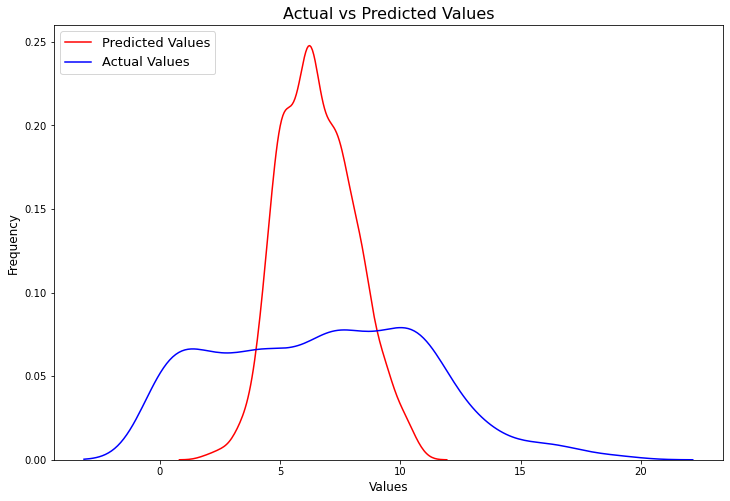

In [22]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.distplot(y_pred_linear, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(Y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)


Judging by these plots it seems that a multiple linear regression model does not fit the data very well. We will try a KNN model as an alternative. 

# KNN Model

scores: [0.5393356643356644, 0.49213286713286714, 0.47027972027972026]


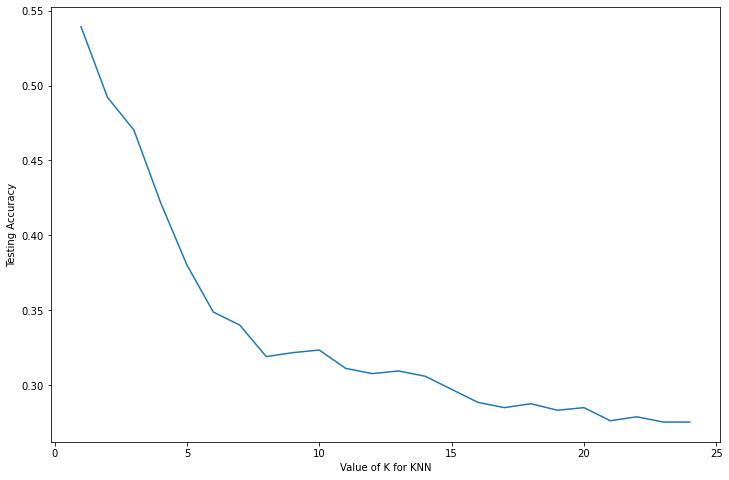

In [23]:
scores = []
for i in range(1,25):
    knnmodel_test = KNeighborsClassifier(n_neighbors=i)
    knnmodel_test.fit(X_train,Y_train)
    y_pred_test = knnmodel_test.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, y_pred_test)
    #print("k:", i , "accuracy:", accuracy)
    scores.append(accuracy)
    
plt.plot([x for x in range(1,25)], scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
  
print("scores:", scores[0:3])


In [24]:
#k=3 chosen to ensure the model isn't overfitted
knnmodel = KNeighborsClassifier(n_neighbors=3)
knnmodel.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=3)

In [25]:
#predicting from the test set 
y_pred_knn = knnmodel.predict(X_test)

In [26]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred_knn))

Accuracy: 0.47027972027972026


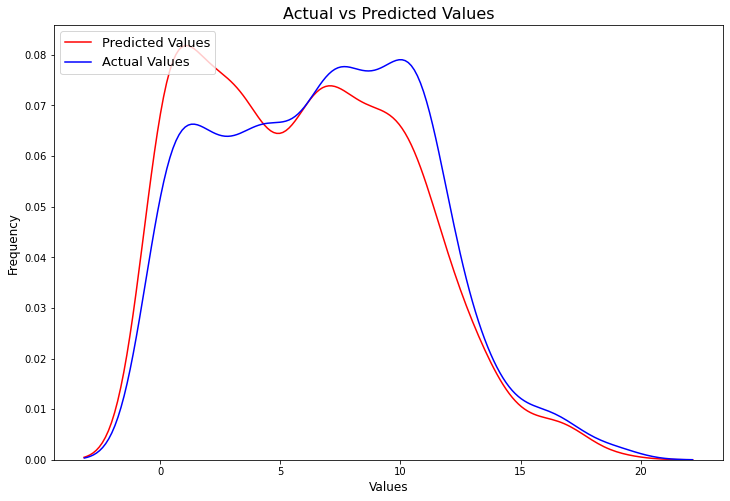

In [27]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.distplot(y_pred_knn, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(Y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)


In [28]:
#some evaluation metrics, all seems good, R2 value is higher than linear regression model 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_knn))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_knn))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_knn)))
print('R-squared:', r2_score(Y_test, y_pred_knn))

Mean Absolute Error: 1.2508741258741258
Mean Squared Error: 6.22465034965035
Root Mean Squared Error: 2.494924918639908
R-squared: 0.6623694578381663


In [32]:
#further evaluation by cross fold evaluation 
#TimeSeriesSplit used to ensure data order is correct 
tscv = TimeSeriesSplit(n_splits=5)
RMSE = []
MAE = []
for train_index, test_index in tscv.split(X_stand):
    print("training set length:", len(train_index), "testing set length length:", len(test_index))

    X_CV_train, X_CV_test = X_stand.iloc[train_index], X_stand.iloc[test_index]
    Y_CV_train, Y_CV_test = y.iloc[train_index], y.iloc[test_index]
    
    
    knnmodel.fit(X_CV_train,Y_CV_train)
    predicted_y = knnmodel.predict(X_CV_test)
    
    RMSE_val = np.sqrt(metrics.mean_squared_error(Y_CV_test, predicted_y))
    MAE_val =  metrics.mean_absolute_error(Y_CV_test, predicted_y)
    
    print('Mean Absolute Error:', MAE_val)
    print('Root Mean Squared Error:', RMSE_val, '\n')

    RMSE.append(RMSE_val)
    MAE.append(MAE_val)
    
average_RMSE_val= np.mean(RMSE)
average_MAE_val= np.mean(MAE)

print("Average Mean Absolute Error:", average_MAE_val)
print("Average RMSE value:", average_RMSE_val)

training set length: 636 testing set length length: 635
Mean Absolute Error: 4.311811023622047
Root Mean Squared Error: 5.3214763211180856 

training set length: 1271 testing set length length: 635
Mean Absolute Error: 5.022047244094488
Root Mean Squared Error: 6.171435341411943 

training set length: 1906 testing set length length: 635
Mean Absolute Error: 5.579527559055118
Root Mean Squared Error: 6.661796121096406 

training set length: 2541 testing set length length: 635
Mean Absolute Error: 4.710236220472441
Root Mean Squared Error: 5.675059401680164 

training set length: 3176 testing set length length: 635
Mean Absolute Error: 4.70236220472441
Root Mean Squared Error: 5.8761495775948145 

Average Mean Absolute Error: 4.865196850393701
Average RMSE value: 5.941183352580284


In [33]:
#prediciton example
#three continuos variables
prediction_array = [(11-scaled['temp'][0])/scaled['temp'][1], (64 - scaled['humidity'][0])/scaled['humidity'][1],
                    (1.12 - scaled['wind_speed'][0])/scaled['wind_speed'][1]]

#categorical variables
main = (0,1,0,0,0,0,0)
hour = (0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0)
day = (0,0,1,0,0,0,0)

prediction_array.extend(main)
prediction_array.extend(hour)
prediction_array.extend(day)

prediction_array
predicted_availability = knnmodel.predict([prediction_array])
predicted_availability

array([9])